In [46]:
# === Install Library (hanya sekali di Colab) ===
!pip install pandas scikit-learn matplotlib seaborn wordcloud


In [47]:
# === Import Libraries ===
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    accuracy_score, precision_score, recall_score, f1_score
)


In [41]:
# === Upload Data ===
from google.colab import files
uploaded = files.upload()  # Upload komen.csv dan stopwords.txt

Saving stopwords.txt to stopwords (1).txt
Saving komen.csv to komen.csv


In [48]:
# === Load Data ===
df = pd.read_csv("komen.csv", delimiter=';', encoding='utf-8')
df = df.dropna(subset=['comment'])  # Hapus komentar kosong


In [50]:

with open('stopwords.txt', 'r', encoding='utf-8') as f:
    stop_words = set(f.read().splitlines())

def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-z\s]", " ", text)
    words = text.split()
    filtered = [word for word in words if word not in stop_words and word.isalpha()]
    return ' '.join(filtered)

df['clean_comment'] = df['comment'].apply(clean_text)

In [51]:
# === Labeling Dukungan ===
pro_aceh_keywords = [
    "dukung aceh", "mendukung aceh", "kami dukung", "saya dukung", "aceh kuat", "hidup aceh", "bela aceh", "kami aceh",
    "aceh damai", "hak aceh", "harga diri", "wilayah aceh", "cinta aceh", "kembalikan", "atjeh", "aceh istimewa",
    "rakyat aceh", "kembalikan aceh", "pertahankan aceh", "jangan ganggu", "kami bersama aceh", "kami dari aceh",
    "kami mendukung aceh", "4 pulau aceh", "milik aceh", "punya aceh", "pecat tito", "pecat mendagri", "turunkan boby",
    "mendukung warga aceh", "dukung atjeh", "mendukung penuh aceh", "pecat si tito", "copot tito", "pecat", "copot",
    "pecat aja", "pecat boboy", "solo", "turunkan"
]

pro_sumut_keywords = [
    "dukung sumut", "dukung sumatera utara", "sumut berhak", "milik tapanuli tengah", "sumut adalah bagian sah",
    "setuju dengan sumut", "sumut tidak salah", "tetap sumut", "bela sumut", "kemenangan sumut", "sumut menang",
    "pro sumut", "sumut tetap milik kita", "bela sumatera utara", "sumut jangan dilepaskan", "kami dari sumut",
    "kami cinta sumut", "jangan ganggu sumut", "sumut tetap utuh", "punya medan", "punya sumut", "dukung medan",
    "dukung boby"
]

def label_dukungan(text):
    text = text.lower()
    if any(k in text for k in pro_aceh_keywords):
        return 'pro_aceh'
    elif any(k in text for k in pro_sumut_keywords):
        return 'pro_sumut'
    else:
        return 'tidak_jelas'

df['dukungan'] = df['comment'].apply(label_dukungan)

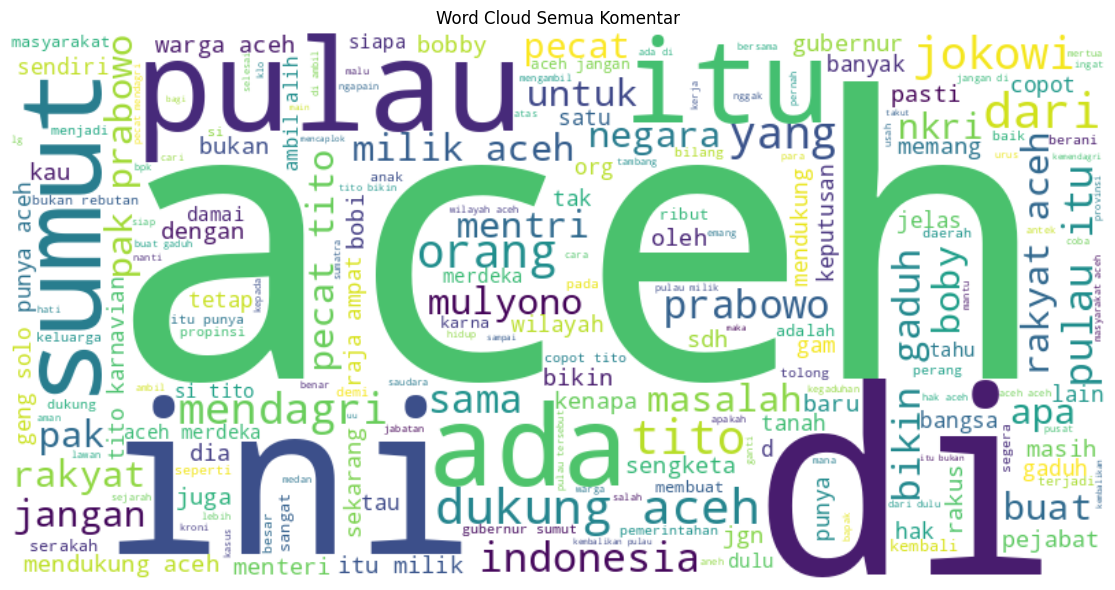

In [52]:
all_text = ' '.join(df['clean_comment'].dropna().astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(all_text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title("Word Cloud Semua Komentar")
plt.axis('off')
plt.tight_layout()
plt.show()

/tmp/ipython-input-53-1889772632.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='dukungan', palette='Set2')


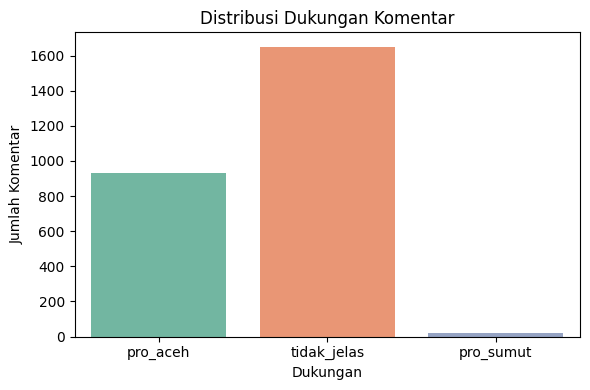


=== Jumlah Dukungan Komentar ===
dukungan
tidak_jelas    1650
pro_aceh        930
pro_sumut        22
Name: count, dtype: int64


In [53]:
# === Distribusi Dukungan ===
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='dukungan', palette='Set2')
plt.title("Distribusi Dukungan Komentar")
plt.xlabel("Dukungan")
plt.ylabel("Jumlah Komentar")
plt.tight_layout()
plt.show()

print("\n=== Jumlah Dukungan Komentar ===")
print(df['dukungan'].value_counts())

In [54]:
print("\n=== Contoh Komentar Pro Aceh ===")
print(df[df['dukungan'] == 'pro_aceh'][['comment']].head(10))


=== Contoh Komentar Pro Aceh ===
                                              comment
0                  OMON OMON tak berani pecat tito   
1                                          pecat tito
2                                    kami dukung aceh
5   KAMI DARI LOMBOK MENDUKUNG PENUH SAUDARA2 ACEH...
7                         Saya orang jawa dukung aceh
9      Trimakasih bnyak antusias sudah mendukung Aceh
12  Prabowo kembalikan 4 pulau ke Aceh  Ganti Tito...
14  Saya orang jabar kuningan  saya mendukung aceh...
15          pecat tito karna dia yg membuat kegaduhan
17                                pecat tito & Bobby 


In [55]:
print("\n=== Contoh Komentar Pro Sumut ===")
print(df[df['dukungan'] == 'pro_sumut'][['comment']].head(10))


=== Contoh Komentar Pro Sumut ===
                                               comment
20                                        dukung sumut
54                       Saya mendukung sumut dan boby
183                                       dukung medan
199                                        punya medan
245              punya sumut karena dekat dengan sumut
306                   secara geografis itu punya sumut
307                     punya sumut di tapanuli tengah
319                   secara geografis itu punya sumut
344  saya orang sumut akan memperjuangkan hak, saya...
497                seharusnya sumut berhak memilikinya


In [56]:
# === TF-IDF & Model Preparation ===
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df['clean_comment'])
y = df['dukungan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [57]:
# === Train Models ===
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Naive Bayes': MultinomialNB()
}
predictions = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    predictions[name] = pred

In [58]:
# === Evaluasi Metrik Model ===
hasil_evaluasi = pd.DataFrame(columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])

for name, pred in predictions.items():
    acc = accuracy_score(y_test, pred)
    prec = precision_score(y_test, pred, average='macro', zero_division=0)
    rec = recall_score(y_test, pred, average='macro', zero_division=0)
    f1 = f1_score(y_test, pred, average='macro', zero_division=0)

    hasil_evaluasi = pd.concat([hasil_evaluasi, pd.DataFrame([{
        'Model': name,
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'F1 Score': f1
    }])], ignore_index=True)

print("\n=== Perbandingan Kinerja Model ===")
print(hasil_evaluasi.round(4))


=== Perbandingan Kinerja Model ===
                 Model  Accuracy  Precision  Recall  F1 Score
0        Random Forest    0.9213     0.9525  0.6832    0.7409
1  Logistic Regression    0.8925     0.6011  0.5746    0.5842
2          Naive Bayes    0.8618     0.5813  0.5465    0.5577


/tmp/ipython-input-58-3523448383.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  hasil_evaluasi = pd.concat([hasil_evaluasi, pd.DataFrame([{


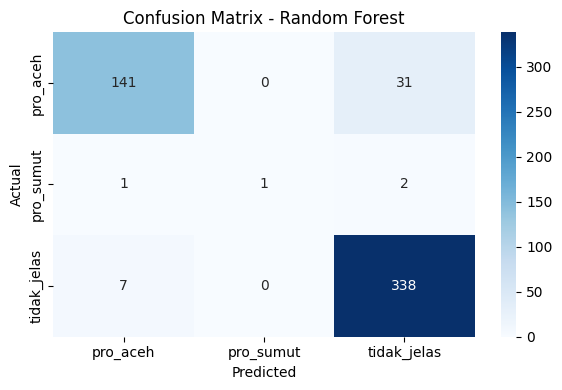

In [59]:
# === Confusion Matrix Random Forest ===
from sklearn.metrics import confusion_matrix

labels = sorted(y_test.unique())
cm = confusion_matrix(y_test, predictions['Random Forest'], labels=labels)

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Random Forest')
plt.tight_layout()
plt.show()

/tmp/ipython-input-61-1305310645.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_importances, y=top_features, palette='viridis')


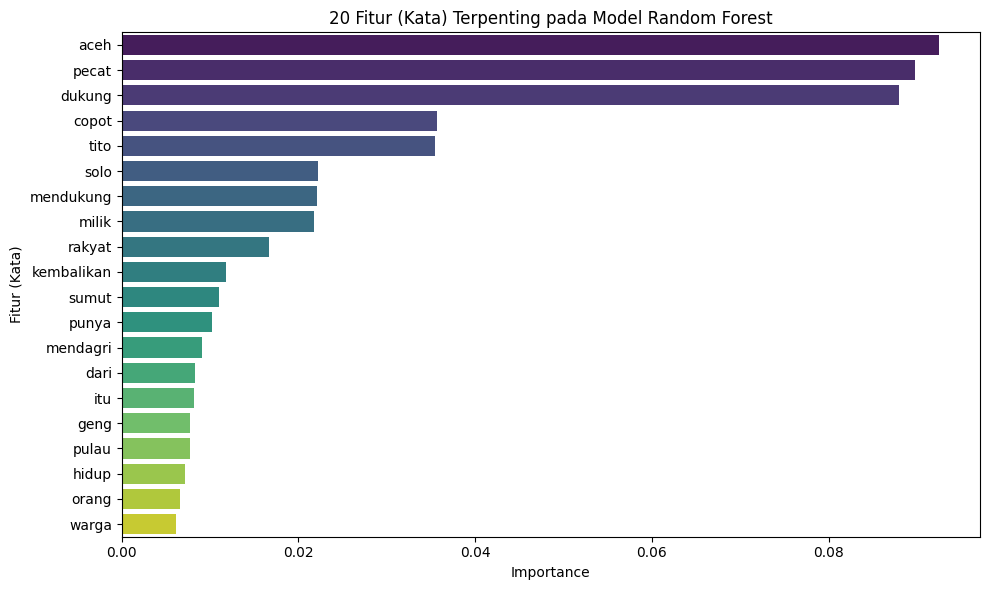

In [61]:
# Ambil fitur dan importance dari model
import numpy as np

# Dapatkan nama fitur dari TF-IDF
feature_names = tfidf.get_feature_names_out()
importances = models['Random Forest'].feature_importances_

# Ambil 20 fitur terpenting
indices = np.argsort(importances)[-20:][::-1]
top_features = [feature_names[i] for i in indices]
top_importances = importances[indices]

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(x=top_importances, y=top_features, palette='viridis')
plt.title("20 Fitur (Kata) Terpenting pada Model Random Forest")
plt.xlabel("Importance")
plt.ylabel("Fitur (Kata)")
plt.tight_layout()
plt.show()

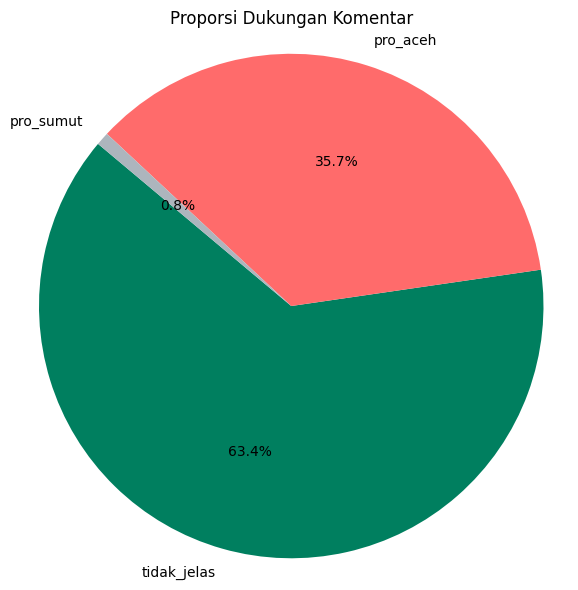

In [62]:
# Pie chart dukungan
dukungan_counts = df['dukungan'].value_counts()

plt.figure(figsize=(6, 6))
colors = ['#007f5f', '#ff6b6b', '#adb5bd']
plt.pie(dukungan_counts, labels=dukungan_counts.index, autopct='%1.1f%%', colors=colors, startangle=140)
plt.title("Proporsi Dukungan Komentar")
plt.axis('equal')
plt.tight_layout()
plt.show()

In [ ]:
# === Simpan Hasil ===
df.to_csv("hasil_analisis_dukungan.csv", index=False)
print("✅ Hasil analisis disimpan sebagai hasil_analisis_dukungan.csv")